In [1]:
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
from sklearn.datasets import fetch_openml

In [3]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

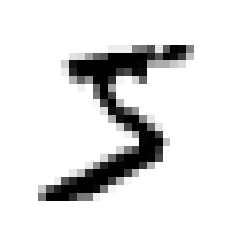

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [7]:
y[0]

'5'

In [8]:
y = y.astype(np.uint8)
y[0]

5

 Create a test test and training set (MNIST already does that - and it is also shuffled to guarantee that all numbers exist in both sets)

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [10]:
# training a binary classifier
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [11]:
# Stochastic Gradient Descent
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [12]:
sgd_clf.predict([some_digit])

array([ True])

## Performance - binary classifiers

In [13]:
# implementing cross-validation
def cross_validation():
    from sklearn.model_selection import StratifiedKFold
    from sklearn.base import clone
    
    skfolds = StratifiedKFold(n_splits=3, random_state=42)
    
    for train_index, test_index in skfolds.split(X_train, y_train_5):
        clone_clf = clone(sgd_clf)
        X_train_folds = X_train[train_index]
        y_train_folds = y_train_5[train_index]
        X_test_fold = X_train[test_index]
        y_test_fold = y_train_5[test_index]
        
        clone_clf.fit(X_train_folds, y_train_folds)
        y_pred = clone_clf.predict(X_test_fold)
        n_correct = sum(y_pred == y_test_fold)
        print(n_correct/len(y_pred))

In [14]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [15]:
# another model
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self,X, y=None):
        return self
    def predict(self,X):
        return np.zeros((len(X), 1), dtype=bool)

In [16]:
never_5_clf = Never5Classifier()

In [17]:
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy") 
# it seems to work well because 90% of all images are not 5

array([0.91125, 0.90855, 0.90915])

### Confusion Matrix
Count the number of times intances of a class A are classified as class B

In [18]:
from sklearn.model_selection import cross_val_predict # makes predictions
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [19]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [20]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

In [21]:
# true positive rate
from sklearn.metrics import precision_score, recall_score

In [22]:
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [23]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [24]:
from sklearn.metrics import f1_score

In [25]:
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [26]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [27]:
threshold = 0

In [28]:
y_some_digit_pred = (y_scores>threshold)

In [29]:
y_some_digit_pred 

array([ True])

In [30]:
threshold = 8000
y_some_digit_pred = (y_scores>threshold)

In [31]:
y_some_digit_pred #confirms that raising the threshold decreases recall

array([False])

Deciding what threshold will be used:

In [32]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [33]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [34]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    p1, = plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    p2, = plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.grid()
    plt.rcParams["figure.figsize"] = (16, 6)
    plt.legend([p1, p2], ["Precision", "Recall"])

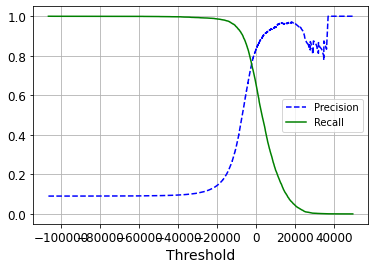

In [35]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

Another option: Plot precision directly against recall

In [36]:
# I need 90% precision
threshold_90_precision = thresholds[np.argmax(precisions>= 0.90)]
threshold_90_precision

3370.0194991439557

In [37]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [38]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [39]:
recall_score(y_train_5, y_train_pred_90) #too low...

0.4799852425751706

ROC Curve - Receiver Operating Characteristic curve

In [40]:
from sklearn.metrics import roc_curve
fpr,tpr, thresholds = roc_curve(y_train_5, y_scores)

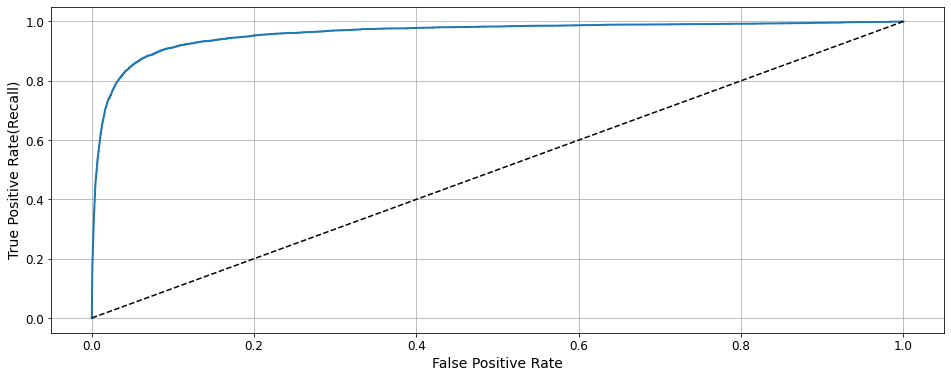

In [41]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--') #dashed diagonal (ROC curve)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate(Recall)")
    plt.grid()
    plt.rcParams["figure.figsize"] = (8, 6)
    
plot_roc_curve(fpr,tpr)
plt.show()

In [42]:
#Area under the curve(AUC) - compare classifiers
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [43]:
# RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [44]:
y_scores_forest = y_probas_forest[:, 1] #score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

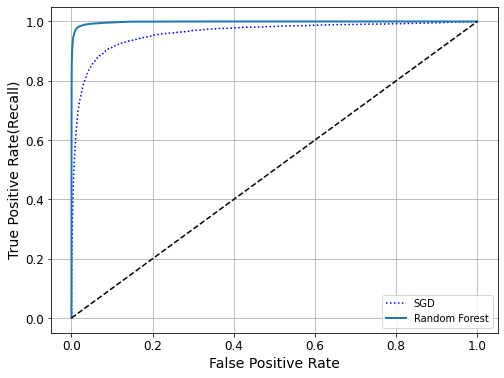

In [45]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest,"Random Forest")
plt.legend(loc="lower right")
plt.show() #shows that Random Forest classifier is superior to the SGD classifier

In [46]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

## Multiclass Classification

In [49]:
from sklearn.svm import SVC # trains 45 binary classifiers (One versus One)
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [50]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [51]:
np.argmax(some_digit_scores) # highest score

5

In [52]:
svm_clf.classes_ #list of target classes

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [53]:
svm_clf.classes_[5] # sometimes the index corresponds to the class itself

5

In [76]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))

In [77]:
ovr_clf.fit(X_train[:1000], y_train[:1000])

OneVsRestClassifier(estimator=SVC(gamma='auto', random_state=42))

In [78]:
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [79]:
len(ovr_clf.estimators_)

10

Scikit-learn does not run OvR or OvO for SGD classifier because it directly classifies instances into multiple classes

In [80]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [81]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [82]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [83]:
# increasing accuracy above 89%
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

### Error Analysis

In [84]:
y_train_predict = cross_val_predict(estimator=sgd_clf, X=X_train_scaled, y=y_train, cv=3)

In [85]:
conf_mx = confusion_matrix(y_train, y_train_predict)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

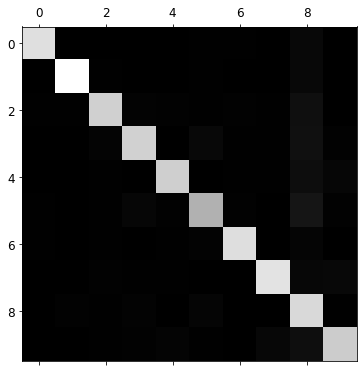

In [86]:
plt.matshow(A =conf_mx, cmap=plt.cm.gray)
plt.show()

In [87]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx/row_sums

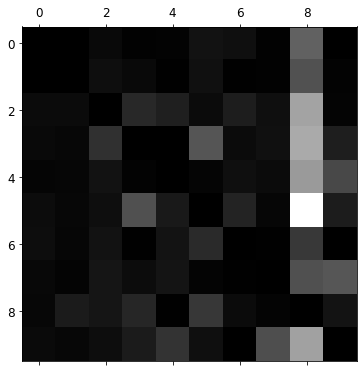

In [88]:
np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [93]:
# analysing individual errors
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_predict == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_predict == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_predict == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_predict == cl_b)]

In [94]:
from math import ceil

In [95]:
def plot_digits(instances, images_per_row=10, **options):
    """Plots digits on a grid of rows and columns
    
    # Arguments
        instances: np.ndarray, the digits, where each is a flat array
        images_per_row: int, how many digits to be displayed per row
        options: other arguments for `plt.imshow()`
    """
    size = 28
    n_images = instances.shape[0]
    images_per_row = min(images_per_row, n_images)
    images = [instance.reshape(size, size) for instance in instances]
    n_rows = ceil(n_images / images_per_row)
    row_images = list()
    n_empty = (n_rows * images_per_row) - n_images
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row*images_per_row : (row+1)*images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap='binary', **options)
    plt.axis('off')

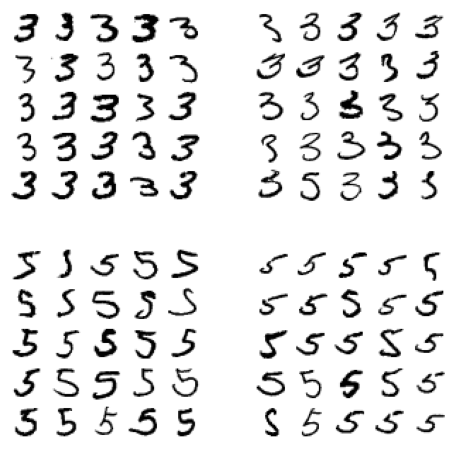

In [96]:
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

### Multilabel Classification
2 target labels: the first indicates whether or not the digit is large and the second indicates whether or not it is odd

In [97]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

In [103]:
knn_clf = KNeighborsClassifier(n_jobs=-1)
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(n_jobs=-1)

In [104]:
knn_clf.predict([some_digit])

array([[False,  True]])

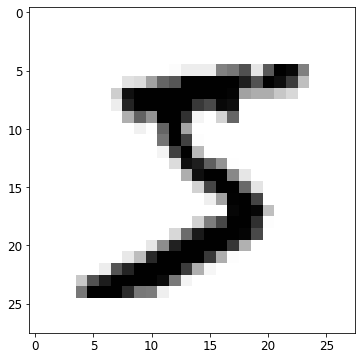

In [105]:
plt.imshow(some_digit.reshape(28, 28), cmap='binary')

In [106]:
from sklearn.metrics import f1_score

In [108]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

### Multioutput Classification
Removing noise from images

In [116]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
X_train_mod.shape

(60000, 784)

In [117]:
noise = np.random.randint(low=0, high=100, size=(X_test.shape[0], 784))
X_test_mod = X_test + noise
X_test_mod.shape

(10000, 784)

In [118]:
y_train_mod = X_train.copy()
y_test_mod = X_test.copy()

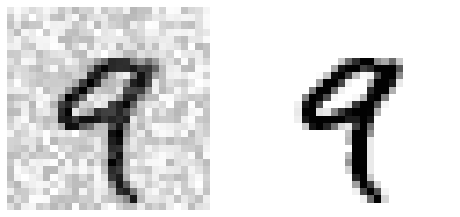

In [119]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(X_train_mod[4:5].reshape(28, 28), cmap='binary'); ax[0].axis('off')
ax[1].imshow(y_train_mod[4:5].reshape(28, 28), cmap='binary'); ax[1].axis('off')
plt.show()

In [120]:
knn_clf.fit(X=X_train_mod, y=y_train_mod)

KNeighborsClassifier(n_jobs=-1)

In [121]:
clean_digit = knn_clf.predict(X=[X_test_mod[234]]).reshape(28, 28)

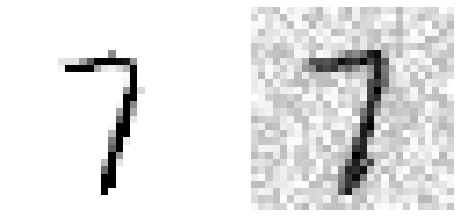

In [122]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(clean_digit, cmap='binary'); ax[0].axis('off')
ax[1].imshow(X_test_mod[234].reshape(28, 28), cmap='binary'); ax[1].axis('off')
plt.show()

---
# 97% accuracy 

In [ ]:
# 16 hours to run
from sklearn.model_selection import GridSearchCV

param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3)
grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_score_

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

---
# Data augmentation - image rotation

In [123]:
from scipy.ndimage.interpolation import shift

In [124]:
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

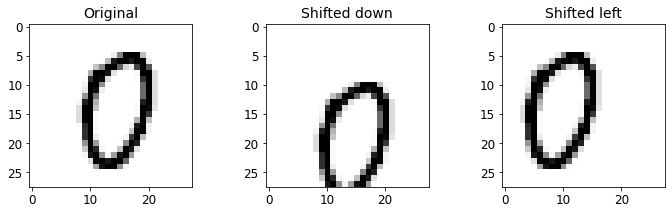

In [125]:
image = X_train[1000]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

In [127]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [ ]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [ ]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)

In [ ]:
knn_clf.fit(X_train_augmented, y_train_augmented)

In [ ]:
# 1 hour to run
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)